# RandomForest- Bank deposit prediction


## Importing Libraries

In [145]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

## Importing Data
### This dataset provides the Train and Test data. No need to split using Train_test

In [109]:
BankDepositsTrain = pd.read_csv('C:/Users/Jody/Documents/data sets/Bank Term Deposit Prediction/train.csv')
BankDepositsTest = pd.read_csv('C:/Users/Jody/Documents/data sets/Bank Term Deposit Prediction/test.csv')

## Indentification and removal of outliers

In [111]:
int_columns = []

for column in BankDepositsTrain.select_dtypes(include='int'):
    int_columns.append(column)

    
Q1 = BankDepositsTrain[int_columns].quantile(0.25)
Q3 = BankDepositsTrain[int_columns].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5

Outliers = (( BankDepositsTrain[int_columns] < (Q1- threshold * IQR))|( BankDepositsTrain[int_columns] > (Q3+ threshold * IQR))).any(axis = 1)


BankDepositsTrainclean = BankDepositsTrain[~Outliers]
BankDepositsTrainclean.info()



<class 'pandas.core.frame.DataFrame'>
Index: 28193 entries, 0 to 45209
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        28193 non-null  int64 
 1   job        28193 non-null  object
 2   marital    28193 non-null  object
 3   education  28193 non-null  object
 4   default    28193 non-null  object
 5   balance    28193 non-null  int64 
 6   housing    28193 non-null  object
 7   loan       28193 non-null  object
 8   contact    28193 non-null  object
 9   day        28193 non-null  int64 
 10  month      28193 non-null  object
 11  duration   28193 non-null  int64 
 12  campaign   28193 non-null  int64 
 13  pdays      28193 non-null  int64 
 14  previous   28193 non-null  int64 
 15  poutcome   28193 non-null  object
 16  y          28193 non-null  object
dtypes: int64(7), object(10)
memory usage: 3.9+ MB


## Hot-encoding categorical variables

In [112]:

label_encoder = LabelEncoder()

Train = BankDepositsTrainclean.copy()
Test = BankDepositsTest.copy()

for column in Train.select_dtypes(include='object'):
    Train[column] = label_encoder.fit_transform(Train[column])
   
    
for column in Test.select_dtypes(include='object'):
    Test[column] = label_encoder.fit_transform(Test[column])
    



## Heatmap to identify correlation

### Noticed 3 variables were nan and therefore showing blank on the heatmap ( 2 int and 1 categorical)
### It appears that the 2 int columns were removed because they were mostly outliers.

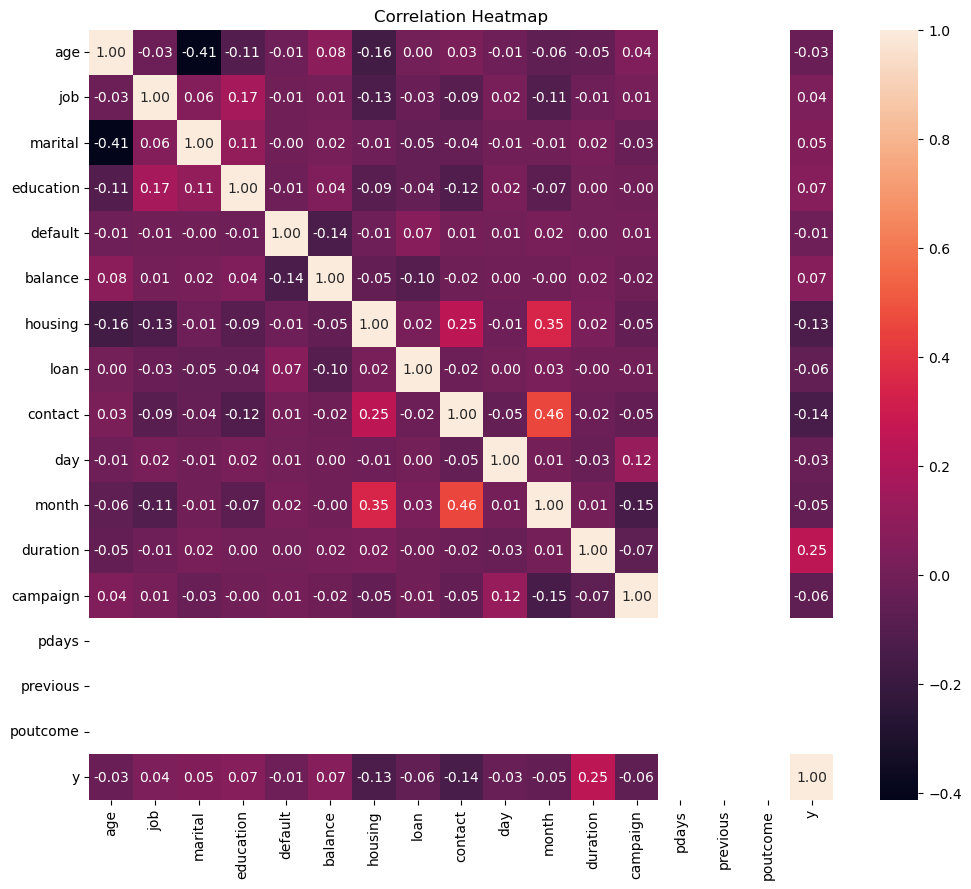

In [113]:
correlation = Train.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### Boxplots were created to visualize the contents of the orginal dataframe to determine the extent of the outliers.
### The plots show how large number of outliers

Text(0.5, 1.0, 'poutcome outliers')

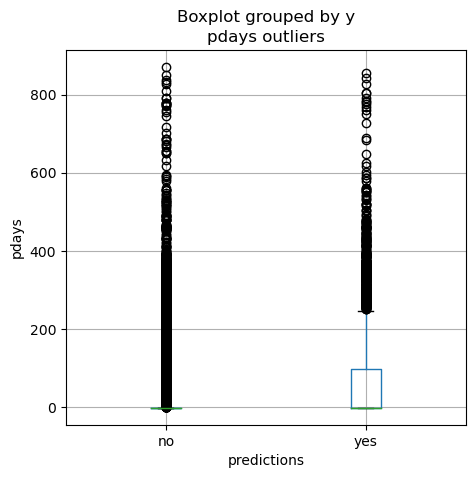

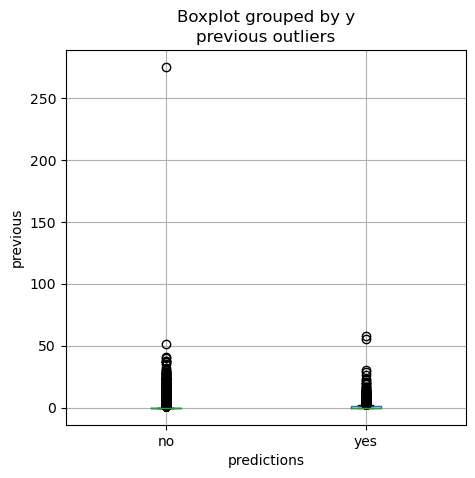

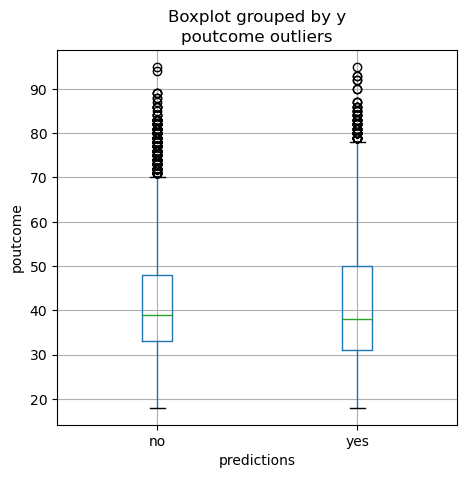

In [144]:
ax = BankDepositsTrain.boxplot(column = ['pdays'], by = 'y', figsize = [5,5])
ax.set_ylabel('pdays')
ax.set_xlabel('predictions')
ax.set_title('pdays outliers')

az = BankDepositsTrain.boxplot(column = ['previous'], by = 'y', figsize = [5,5])
az.set_ylabel('previous')
az.set_xlabel('predictions')
az.set_title('previous outliers')




### All relationships with lower than 5% + or - were removed from the heatmap, as these were determined not
### insignificant

In [114]:
threshold = 0.05

low_corr = Train.columns[abs(Train.corr()['y']) < threshold]

Trainfilter = Train.drop(low_corr, axis = 1)

Testfilter = Test.drop(low_corr, axis = 1)
Testfilter

,marital,education,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,1,0,1787,0,0,0,79,1,-1,0,3,0
1,1,1,4789,1,1,0,220,1,339,4,0,0
2,2,2,1350,1,0,0,185,1,330,1,0,0
3,1,2,1476,1,1,2,199,4,-1,0,3,0
4,1,1,0,1,0,2,226,1,-1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4516,1,1,-333,1,0,0,329,5,-1,0,3,0
4517,1,2,-3313,1,1,2,153,1,-1,0,3,0
4518,1,1,295,0,0,0,151,11,-1,0,3,0
4519,1,1,1137,0,0,0,129,4,211,3,1,0


### Oversampling to mitigate class imbalances

In [115]:
class_0 = Trainfilter[Trainfilter['y']==0]
class_1 = Trainfilter[Trainfilter['y']==1]

print(class_1.shape, class_0.shape)

(1599, 12) (26594, 12)


In [116]:
Class1regularsample = class_1
Class0oversample = class_0.sample(26594, replace = True) ## the true allowed the sample amount to go passed the 354 by 
                                                        ## duplicating records

## after the sample was increased the the class1 dataframe and class 0 data frame where appened together to form the new
## dataframe to model.
TrainCleanandSampled = pd.concat([Class1regularsample,Class0oversample], axis = 0)
TrainCleanandSampled.shape

(28193, 12)

### The nan columns due to the removal of outliers from the previous points were removed 
###  Creation of X Train, Y Train etc

In [160]:
X_Train = TrainCleanandSampled.drop(['pdays','previous','poutcome','y'], axis = 1)
Y_Train = TrainCleanandSampled['y']
X_Test = Testfilter.drop(['pdays','previous','poutcome','y'], axis = 1)
Y_Test = Testfilter['y']

### Using NP to create arrays coupled with grid search to hypertune the random forest model

In [162]:
import numpy as np
rf = RandomForestClassifier(random_state = 42)
n_estimators_range = np.arange(10,210,10)
max_depth_range = np.arange(0,30,5)
criterion_list = ['entropy', 'gini']
min_samples_split_range = np.arange(0,30,5)
min_samples_leaf_range = np.arange(1,9,1)


param_grid = dict(n_estimators=n_estimators_range, 
                  criterion = criterion_list,  
                  max_depth = max_depth_range,
                  min_samples_split = min_samples_split_range,
                  min_samples_leaf = min_samples_leaf_range)

param_grid


grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_Train, Y_Train)


best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)

C:\Users\Jody\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
17600 fits failed out of a total of 57600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9600 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jody\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jody\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\Jody\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Jody\anaconda3\Lib\site-packag

Best Parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 80}


In [165]:
y_pred = best_estimator.predict(X_Test)

In [167]:
cr = classification_report(Y_Test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      4000
           1       0.52      0.13      0.21       521

    accuracy                           0.89      4521
   macro avg       0.71      0.56      0.57      4521
weighted avg       0.85      0.89      0.85      4521

